# Installation pySpark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=be6f3d9011e22958f7565082fb09361284ca84900760739773fa8d2b813a46c9
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# Autorisation accès google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Imports

In [3]:
import os
import io
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA, VectorSlicer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import col, udf, pandas_udf, PandasUDFType, element_at, split
from pyspark.ml.functions import vector_to_array, array_to_vector
from pyspark.ml import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from socket import gethostname
from PIL import Image

# Fonctions

In [4]:
# Création du modèle
def model_fn(weights=None):
    # Charger le modèle MobileNetV2 avec des poids pré-entraînés sur ImageNet
    model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    # Rendre les couches du modèle non-entraînables
    for layer in model.layers:
        layer.trainable = False

    # Créer un nouveau modèle qui prend les mêmes entrées que le modèle MobileNetV2
    # et renvoie les sorties de l'avant-dernière couche
    new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

    # Si des poids sont spécifiés, les appliquer au nouveau modèle
    if weights is not None:
        new_model.set_weights(weights)

    return new_model

# Prétraitement d'une image
def preprocess(content):
    # Ouvrir l'image à partir des données binaires, la redimensionner à 224x224 pixels
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)  # Convertir l'image en tableau
    return preprocess_input(arr)  # Prétraiter l'image

# Fonction pour extraire les caractéristiques d'une série d'images en utilisant un modèle
def featurize_series(model, content_series):
    # Prétraiter chaque image dans la série et faire des prédictions avec le modèle
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # Aplatir les prédictions en un tableau et renvoyer en tant que série Pandas
    output = [p.flatten() for p in preds]
    return pd.Series(output)

# Initialiser une session Spark
spark = SparkSession.builder.appName('P8').config("spark.sql.parquet.writeLegacyFormat", 'true').getOrCreate()
sc = spark.sparkContext

# UDFs pour l'utilisation avec Pandas UDF
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    # Charger le modèle Keras à partir de sa description JSON et des poids
    model = tf.keras.models.model_from_json(broadcast_model_json.value)
    model.set_weights(broadcast_weights.value)
    for content_series in content_series_iter:
        # Extraire les caractéristiques pour chaque série d'images en utilisant le modèle
        yield featurize_series(model, content_series)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


# Initiation des chemins

In [5]:
local = '/drive/My Drive/DataScientist/Projet_8'
cloud = ''

PATH = os.getcwd()
PATH = PATH + local
PATH_input = PATH + '/data/Test_1'
PATH_result = PATH + '/data/Results_2'
PATH_csv = PATH + '/csv/images_pca.csv'
PATH_model = PATH + '/model'
if not os.path.exists(PATH_result):
    os.makedirs(PATH_result)

In [6]:
# %%time
t0 = datetime.datetime.now()
print('Start : ',t0)

# Charger les données
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_input)

# Extraire l'étiquette du chemin puis l'ajouter au df
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print("Taille du DataFrame 'images' :", images.count())

# Charger le modèle pré-entraîné et le diffuser
new_model = model_fn()
broadcast_weights = sc.broadcast(new_model.get_weights())
broadcast_model_json = sc.broadcast(new_model.to_json())

# Extraire les caractéristiques de chaque image à partir de la colonne "content"
# Répartir les données en utilisant un nombre arbitraire (ici, 4 fois le nombre de cœurs CPU)
nb_partition = os.cpu_count() * 4
features_df = images.repartition(nb_partition).select(col("path"),col("label"),featurize_udf("content").alias("features") )
print("Nb des cpu : ",os.cpu_count()," / Nb des partitions : ",nb_partition)

# Créer une UDF pour convertir les caractéristiques en vecteurs
features_vec_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Appliquer l'UDF pour créer une nouvelle colonne "features_vector"
features_df = features_df.withColumn("features_vector", features_vec_udf(features_df["features"]))

# Appliquer PCA
pca = PCA(k=1024, inputCol="features_vector", outputCol="features_pca")
pca_model = pca.fit(features_df)
pca_result = pca_model.transform(features_df)

# Sauvegarder au format Parquet
pca_result.write.mode("overwrite").parquet(PATH_result)
# print("Nombre des Parquet :", pca_result.count())

# Lire les données en utilisant Pandas
df = pd.read_parquet(PATH_result, engine='pyarrow')
print("Taille du résultat : ",df.loc[0,'features'].shape)

# Sauvegarde des résultats au format CSV
df_csv = df[['path', 'label', 'features_pca']]
df_csv.to_csv(PATH_csv, mode='w', index=False)

# Sauvegarder le modèle
# new_model.save(PATH_model)

print(f"Temps d'execution: {datetime.datetime.now() - t0}")

df.head()

Start :  2023-09-20 09:55:12.634961
14536120/14536120 [==============================] - 1s 0us/step
Taille du DataFrame 'images' : 287
Nb des cpu :  2  / Nb des partitions :  8
Taille du résultat :  (1280,)
Temps d'execution: 0:04:00.476606


,path,label,features,features_vector,features_pca
0,file:/content/drive/My Drive/DataScientist/Pro...,zucchini_1,"[0.0, 0.44390363, 0.04866997, 0.0, 1.6742896, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/content/drive/My Drive/DataScientist/Pro...,zucchini_1,"[0.0, 0.54130495, 0.1461673, 0.0, 0.6710353, 0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/content/drive/My Drive/DataScientist/Pro...,zucchini_1,"[0.03395359, 0.56752086, 0.5667388, 0.0, 1.096...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/content/drive/My Drive/DataScientist/Pro...,zucchini_1,"[0.0, 0.5365281, 0.37848508, 0.0, 0.5804875, 0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/content/drive/My Drive/DataScientist/Pro...,zucchini_1,"[0.0, 0.30709398, 0.2530956, 0.0, 2.4174488, 0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


# Visualisation ACP

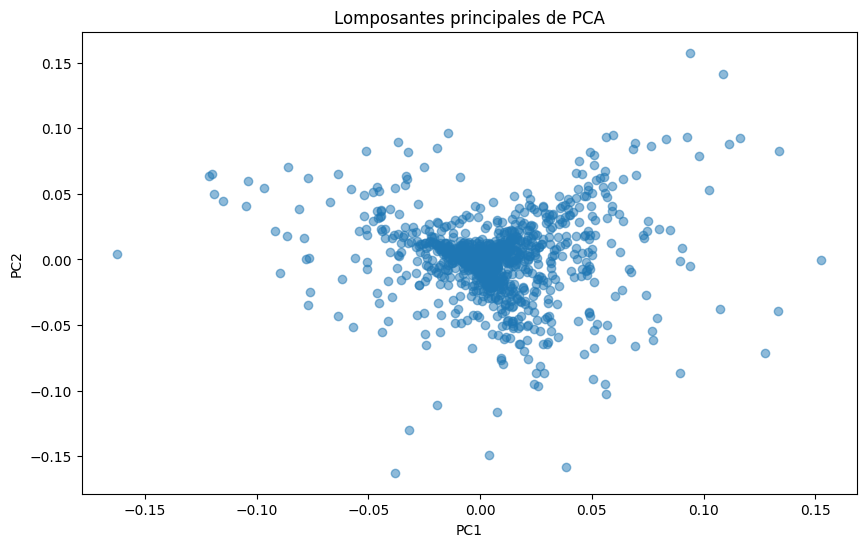

In [7]:
# Collecter les composantes principales à partir du résultat de la PCA
pca_components = pca_model.pc.toArray()

# Plotter les composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Lomposantes principales de PCA')
plt.show()

Je détermine le nombre minimal de composantes principales nécessaires pour expliquer au moins 95% de la variance des données:"


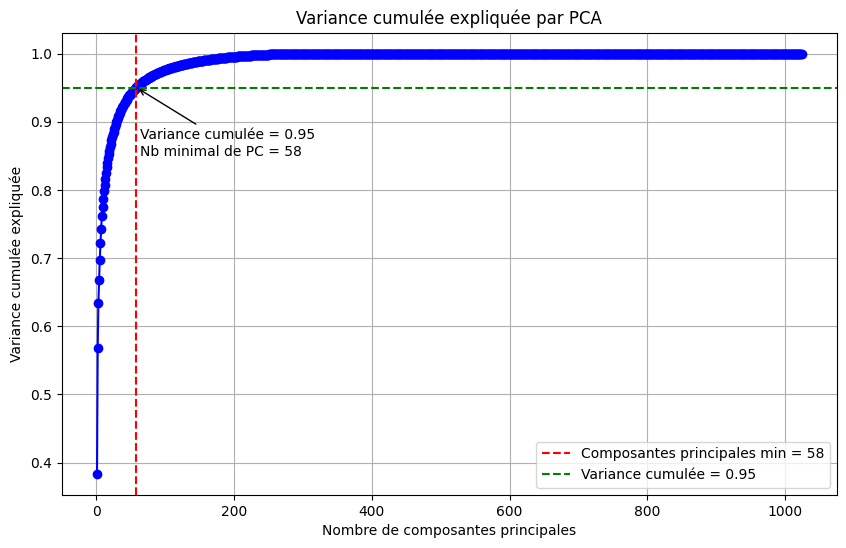

In [10]:
# Récupérer la variance expliquée par chaque composante principale
explained_variance = pca_model.explainedVariance.toArray()

# Calculer la variance cumulée expliquée
cumulative_explained_variance = explained_variance.cumsum()

# Calculer le nombre optimal de composantes principales
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Plotter la variance cumulée expliquée avec la ligne rouge pour la valeur optimale
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_components, color='r', linestyle='--', label=f'Composantes principales min = {optimal_components}')
# plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
# plt.axvline(x=optimal_components, color='r', linestyle='--', label=f'Optimal ({optimal_components} composantes)')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance cumulée expliquée par PCA')

# Ajouter l'annotation pour la valeur de la variance cumulée expliquée à l'emplacement optimal
plt.annotate(f'Variance cumulée = {cumulative_explained_variance[optimal_components - 1]:.2f}\nNb minimal de PC = {optimal_components}',
             xy=(optimal_components, cumulative_explained_variance[optimal_components - 1]),
             xytext=(optimal_components + 5, cumulative_explained_variance[optimal_components - 1] - 0.1),
             arrowprops=dict(arrowstyle='->'))

# Ajouter la ligne horizontale pour la valeur 0.95
plt.axhline(y=0.95, color='g', linestyle='--', label='Variance cumulée = 0.95')

plt.legend()
plt.grid(True)
plt.show()